# Init Environment

## Note

In [ ]:
# note of the module installations
# install python with pyenv (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv)
# setup virtual environment with pyenv (ref:https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#installing-python-with-pyenv
# error: 'Failed to activate virtualenv' (ref:https://github.com/pyenv/pyenv-virtualenv/issues/387)
# pip install fasttext (0.9.2) (after installing the dependencies: numpy, scipy, pybind11, setuptools, wheel)

# install Jupyter notebook and nbextensions (ref: https://github.com/lewagon/data-setup/blob/e5a239926f304d452704718136b6e2f017c7303d/macOS.md#jupyter-notebook-extensions)
#   pip install jupyter_contrib_nbextensions
#   pip install --upgrade notebook==6.4.12 (ref:https://stackoverflow.com/questions/49647705/jupyter-nbextensions-does-not-appear)
#   pip install traitlets==5.9.0

## Import modules

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm import tqdm
import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
from src.helper_text import *
from src.helper_langID import *
from src.helper_translation import *
from src.helper_pred import *

# Combine Data Source

In [ ]:
import glob

# Get a list of file paths that match the pattern
files = glob.glob(f'{DATA_FOLDER_PATH_RAW}/data_202*.xlsx')
# Create an empty list to store DataFrames
dfs = []

# Loop through each file and read it into a DataFrame
for file in files:
    df = pd.read_excel(file, index_col=None)
    dfs.append(df)

# Concatenate the DataFrames into one
df_combined = pd.concat(dfs, ignore_index=True)
df_combined.info()

In [ ]:
#check for null values
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# columns which have large number of null values will be dropped 
columns_to_drop = [
    'Escalated To Engineering', 
    'Bug Type', 
    'Status Reason', 
    'Escalated to L2',
    'Category',
    'Completion Code'
]
try: 
    df_combined.drop(columns_to_drop, axis=1, inplace = True)
    df_combined.dropna(subset=['Request ID'], inplace=True)
    df_combined.dropna(subset=['Product Name'], inplace=True)
    df_combined.dropna(subset=['Title'], inplace=True)
except:
    pass
# surprisingly, there are over 100k duplications
df_combined.drop_duplicates(subset=['Title', 'Product Name'], keep='first', inplace=True)

In [ ]:
df_combined.isnull().sum().sort_values(ascending = False)

In [ ]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'

# Export the DataFrame to Excel
df_combined.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Load Data for Pre-processing

In [3]:
data_url = f'{DATA_FOLDER_PATH_PROCESSED}/data_combined.xlsx'
df_combined = pd.read_excel(data_url, index_col=None)
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168829 entries, 0 to 168828
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             168829 non-null  int64         
 1   Title                  168829 non-null  object        
 2   Created Time           168829 non-null  datetime64[ns]
 3   Customer Company       168650 non-null  object        
 4   Customer Country       168729 non-null  object        
 5   Priority               168829 non-null  object        
 6   Urgency                168829 non-null  object        
 7   Impact                 168829 non-null  object        
 8   Product Name           168829 non-null  object        
 9   Module Name            158114 non-null  object        
 10  Service Definition     168820 non-null  object        
 11  Service Desk Group     167799 non-null  object        
 12  Status                 168829 non-null  obje

# Clean-up the Title Column

## Quick Clean-up

In [5]:
df_processed = df_combined.copy()

df_processed['Length'] = 0
df_processed['Language']=pd.NA
df_processed['Title_Processed']=pd.NA
df_processed['Title_Translated']=pd.NA
df_processed['Tags']=pd.NA

# Set the number of rows to process
num = df_processed['Title'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    # processed_title = preprocess_step_1(df_combined.at[index, 'Title'])
    processed_title = quick_clean_up(df_processed.at[index, 'Title'])
    df_processed.at[index, 'Title_Processed'] = processed_title
    df_processed.at[index, 'Length'] = len(processed_title)
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

Processing Rows: 100%|█████████▉| 168795/168829 [00:14<00:00, 11274.15 row/s]


<class 'pandas.core.frame.DataFrame'>
Index: 160135 entries, 0 to 168828
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             160135 non-null  int64         
 1   Title                  160135 non-null  object        
 2   Created Time           160135 non-null  datetime64[ns]
 3   Customer Company       159976 non-null  object        
 4   Customer Country       160057 non-null  object        
 5   Priority               160135 non-null  object        
 6   Urgency                160135 non-null  object        
 7   Impact                 160135 non-null  object        
 8   Product Name           160135 non-null  object        
 9   Module Name            149967 non-null  object        
 10  Service Definition     160127 non-null  object        
 11  Service Desk Group     159117 non-null  object        
 12  Status                 160135 non-null  object   

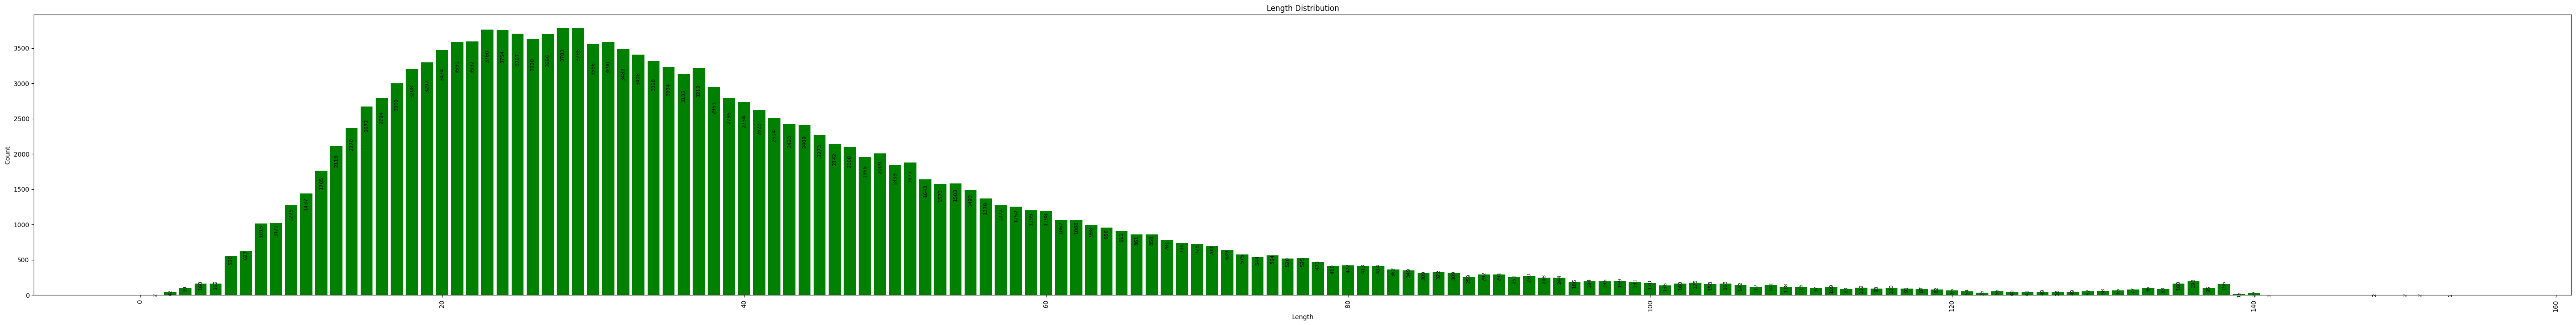

In [6]:
# Delete records with missing values in 'ProductName' columns
df_processed.dropna(subset=['Title_Processed'], inplace=True)
# Remove duplicates based on 'Title' and 'ProductName' columns
df_processed.drop_duplicates(subset=['Title_Processed', 'Product Name'], keep='first', inplace=True)

print(df_processed.info())
hist_by_labels(df_processed, 'Length', log=False)

## Language Detection

In [7]:
# Set the number of rows to process
num = df_processed['Title_Processed'].notnull().sum()

# df['Title_Translated'] = df['Title_Processed']
# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_processed.at[index, 'Language'] = detect_language_fasttext(df_processed.at[index, 'Title_Processed'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_processed.index)

# Close the progress bar
progress_bar.close()

Processing Rows: 100%|██████████| 160135/160135 [00:07<00:00, 21376.83 row/s]


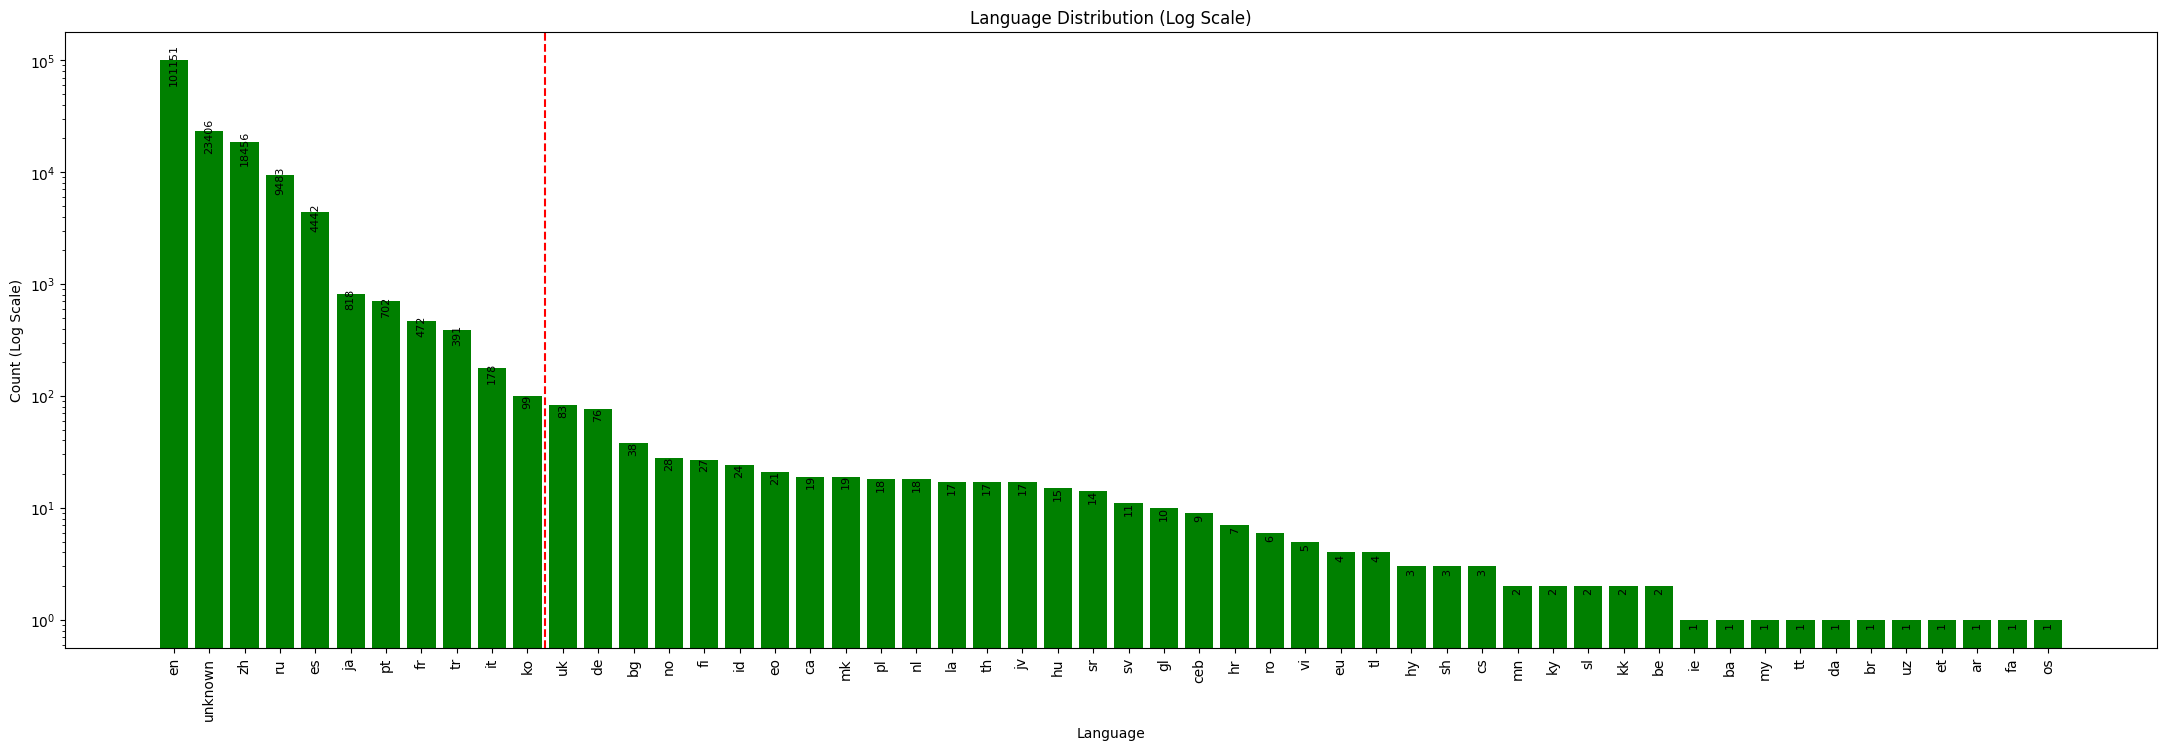

In [8]:
# fasttext performance is better than the other solutions for short text 
# (ref: https://medium.com/besedo-engineering/language-identification-for-very-short-texts-a-review-c9f2756773ad

hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)

In [9]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'

# Export the DataFrame to Excel
df_processed.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Translation of Non-English

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_processed.xlsx'
df_processed = pd.read_excel(excel_file)

<class 'pandas.core.frame.DataFrame'>
Index: 160135 entries, 0 to 168828
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             160135 non-null  int64         
 1   Title                  160135 non-null  object        
 2   Created Time           160135 non-null  datetime64[ns]
 3   Customer Company       159976 non-null  object        
 4   Customer Country       160057 non-null  object        
 5   Priority               160135 non-null  object        
 6   Urgency                160135 non-null  object        
 7   Impact                 160135 non-null  object        
 8   Product Name           160135 non-null  object        
 9   Module Name            149967 non-null  object        
 10  Service Definition     160127 non-null  object        
 11  Service Desk Group     159117 non-null  object        
 12  Status                 160135 non-null  object   

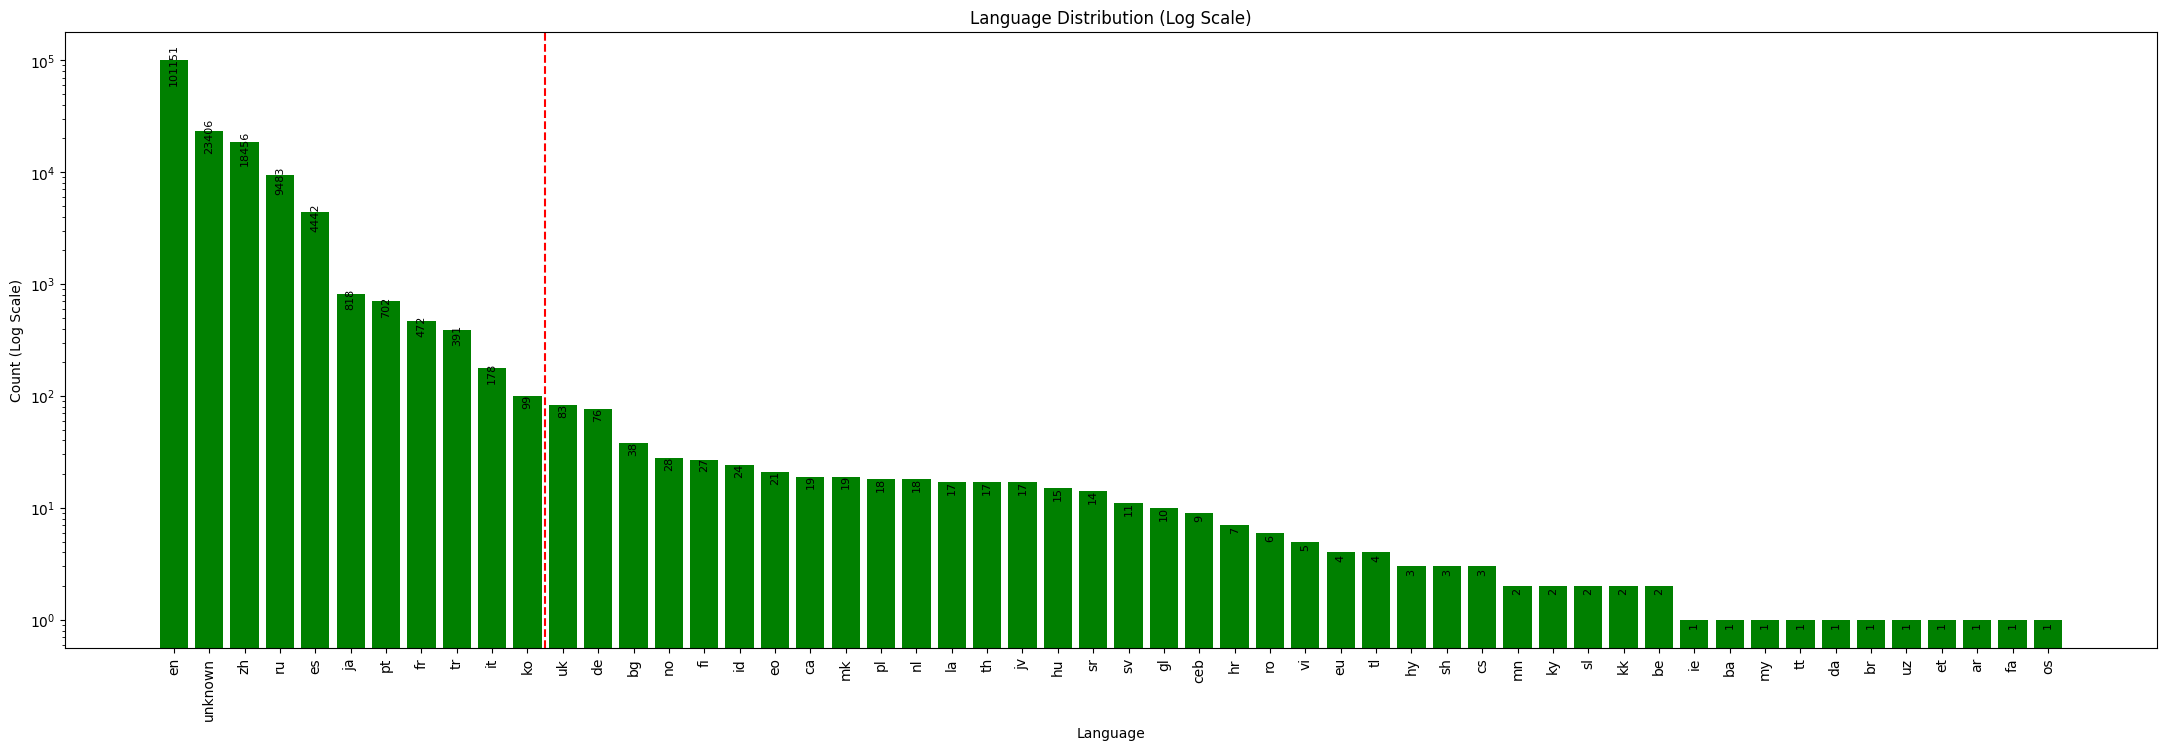

<class 'pandas.core.frame.DataFrame'>
Index: 136192 entries, 0 to 168828
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             136192 non-null  int64         
 1   Title                  136192 non-null  object        
 2   Created Time           136192 non-null  datetime64[ns]
 3   Customer Company       136065 non-null  object        
 4   Customer Country       136134 non-null  object        
 5   Priority               136192 non-null  object        
 6   Urgency                136192 non-null  object        
 7   Impact                 136192 non-null  object        
 8   Product Name           136192 non-null  object        
 9   Module Name            127736 non-null  object        
 10  Service Definition     136187 non-null  object        
 11  Service Desk Group     135308 non-null  object        
 12  Status                 136192 non-null  object   

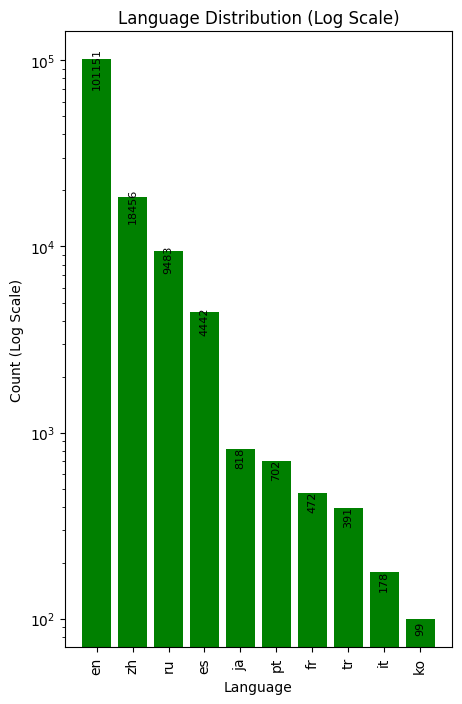

In [10]:
df_translated = df_processed.copy()
df_translated['Title_Translated'] = df_translated['Title_Processed']
print(df_translated.info())

# Keep the top 10 languages and drop the rest and the unknown. 
# why? There are high chances the detected language were not correct due to wrong spelling, etc.
hist_by_labels(df_processed, "Language", log=True, horizontal=True, left=10.5)

language_counts = df_translated['Language'].value_counts()
cutoff = 90
language_others = language_counts.index[language_counts < cutoff]

mask_others = df_translated['Language'].isin(language_others)
df_translated.loc[mask_others,'Language']='unknown'

# Drop rows where 'Language' is equal to 'unknown'
df_translated = df_translated[df_translated['Language'] != 'unknown']
print(df_translated.info())
hist_by_labels(df_translated, 'Language', log=True, horizontal=True)

In [11]:
# Group the DataFrame by the "Language" column
grouped = df_translated.groupby("Language")

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Translating")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for lang, group in grouped:
    pbar.set_description(f"Processing [{lang}/{len(group)}]")

    translated_titles = translate_array(
        group["Title_Translated"].tolist(),
        src_lang=lang,
        tar_lang='en',
        length_limit=1250)
    group["Title_Translated"] = translated_titles  # Update "Title_Translated" column in the group
    
    processed_groups.append(group)
    pbar.update(1)  # Update the progress bar

# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_translated = pd.concat(processed_groups, ignore_index=True)

Processing [zh/18456]: 100%|██████████| 10/10 [04:23<00:00, 26.32s/it]


In [12]:
# convert the abbreviated words to full words
df_translated['Title_Translated'] = df_translated['Title_Translated'].apply(convert_abbrev_in_text)

Tags                     136192
Module Name                8456
Closed Time                2100
Service Desk Group          884
Customer Company            127
Customer Country             58
Service Definition            5
Contracts Reference           2
Resolution Time (Min)         0
Title_Translated              0
Title_Processed               0
Language                      0
Length                        0
Creation Source               0
Created Time                  0
Response Time (Min)           0
Priority                      0
Status                        0
Title                         0
Product Name                  0
Impact                        0
Urgency                       0
Request ID                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 135746 entries, 0 to 136191
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID          

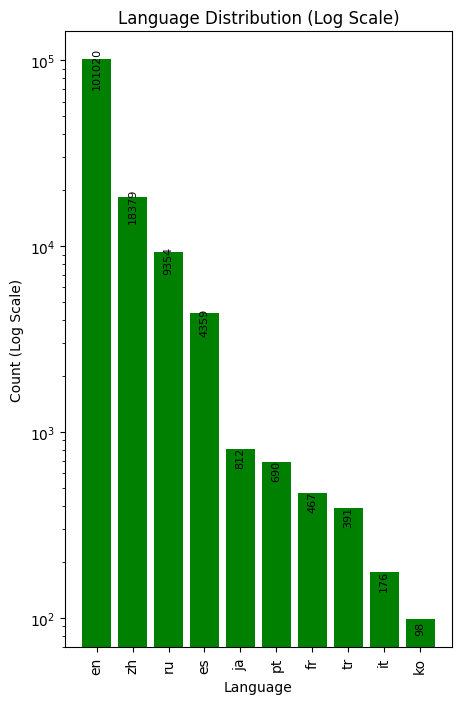

In [13]:
print(df_translated.isnull().sum().sort_values(ascending = False))

# Delete records with missing values in 'ProductName' columns
df_translated.dropna(subset=['Title_Translated'], inplace=True)
# Remove duplicates based on 'Title' and 'ProductName' columns
df_translated.drop_duplicates(subset=['Title_Translated', 'Product Name'], keep='first', inplace=True)
print(df_translated.info())
hist_by_labels(df_translated, 'Language', log=True, horizontal=True)

In [ ]:
df_translated.head(10)

In [14]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'

# Export the DataFrame to Excel
df_translated.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

## Final Clean up

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_translated.xlsx'
df_translated = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})

In [42]:
df_cleaned = df_translated.copy()
print(df_cleaned.info())
df_cleaned.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 135746 entries, 0 to 136191
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Request ID             135746 non-null  int64         
 1   Title                  135746 non-null  object        
 2   Created Time           135746 non-null  datetime64[ns]
 3   Customer Company       135619 non-null  object        
 4   Customer Country       135688 non-null  object        
 5   Priority               135746 non-null  object        
 6   Urgency                135746 non-null  object        
 7   Impact                 135746 non-null  object        
 8   Product Name           135746 non-null  object        
 9   Module Name            127310 non-null  object        
 10  Service Definition     135741 non-null  object        
 11  Service Desk Group     134862 non-null  object        
 12  Status                 135746 non-null  object   

,Request ID,Title,Created Time,Customer Company,Customer Country,Priority,Urgency,Impact,Product Name,Module Name,...,Closed Time,Response Time (Min),Resolution Time (Min),Contracts Reference,Creation Source,Length,Language,Title_Processed,Title_Translated,Tags
0,1705753,OFM Support,2022-12-14 06:29:13,AL-KHAFJI JOINT OPERATIONS (AGOC/KGOC),NaN,P4 Low,This issue disrupts my work,Single user,OFM,Base,...,2022-12-29 06:30:58,0.0000,0.7150,Standard-Software-Maintenance-Contract,Agent Created Ticket,11,en,OFM Support,oil field management (OFM) Support,NaN
1,1130253,Rerun workflow and Create workflow option not ...,2022-01-04 21:52:01,GROUPEMENT REGGANE,ALGERIA,P4 Low,This issue disrupts my work,Single user,Petrel RE,RE - Other,...,2022-01-10 03:16:58,66.0677,0.0000,Standard-Software-Maintenance-Contract,Support Portal,55,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,NaN
2,1130330,[Ext] TR- Registration Completion Notice,2022-01-05 08:07:22,SH - PED,ALGERIA,P4 Low,This issue disrupts my work,Single user,ECLIPSE,Eclipse 100 (Blackoil),...,2022-01-21 08:27:25,37.6989,1402.1556,Standard-Software-Maintenance-Contract,Email,37,en,Ext TR Registration Completion Notice,Ext TR Registration Completion Notice,NaN
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,2022-01-05 14:29:47,SH - PED,ALGERIA,P4 Low,I can continue to work,Multiple users,ProSource,Installation,...,2022-01-05 14:32:14,0.0000,3.2456,Standard-Software-Maintenance-Contract,Agent Created Ticket,29,en,SH PED: Patch for proSource .,SH PED : Patch for proSource .,NaN
4,1131191,SH-PED: issue with ProSource services,2022-01-05 14:34:47,SH - PED,ALGERIA,P2 High,I am blocked from doing my job,Multiple users,ProSource,Administration,...,2022-01-05 14:36:32,0.0000,0.0000,Standard-Software-Maintenance-Contract,Agent Created Ticket,37,en,SH PED: issue with ProSource services,SH PED : issue with ProSource services,NaN
5,1131193,SH-PED: ProSource new License file,2022-01-05 14:38:53,SH - PED,ALGERIA,P4 Low,I can continue to work,Multiple users,ProSource,Installation,...,2022-01-05 14:40:15,1.8040,1.8206,Standard-Software-Maintenance-Contract,Agent Created Ticket,34,en,SH PED: ProSource new License file,SH PED : ProSource new License file,NaN
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,2022-01-08 09:14:32,SH - DP - HMD,ALGERIA,P2 High,I am blocked from doing my job,Multiple users,License,NaN,...,2022-01-24 18:17:23,0.0000,0.0000,Standard-Software-Maintenance-Contract,Agent Created Ticket,42,en,Schlumberger Licensing Tool . not starting,Schlumberger Licensing Tool . not starting,NaN
7,1135119,Production by zone/segment,2022-01-09 21:26:38,ALNAFT,ALGERIA,P3 Medium,This issue partially blocks my work,Single user,Petrel RE,Simulation,...,2022-01-25 07:27:22,0.0000,0.0000,Standard-Software-Maintenance-Contract,Support Portal,26,en,Production by zone segment,Production by zone segment,NaN
8,1136751,data exchanger with client,2022-01-10 09:47:01,SONATRACH DIVISION PRODUCTION,ALGERIA,P4 Low,This issue disrupts my work,Single user,Petrel,Geology,...,2022-01-18 10:07:20,0.1846,4234.9140,Standard-Software-Maintenance-Contract,Agent Created Ticket,26,en,data exchanger with client,data exchanger with client,NaN
9,1140517,"Error: Unable to start external queue, but run...",2022-01-12 16:03:12,GROUPEMENT REGGANE,ALGERIA,P3 Medium,I am blocked from doing my job,Single user,Petrel RE,RE - Other,...,2022-01-20 15:52:23,208.3179,6875.1180,Standard-Software-Maintenance-Contract,Support Portal,58,en,"Error: Unable to start external queue, but run...","Error : Unable to start external queue , but r...",NaN


In [43]:
df_cleaned.drop(columns=[
    'Created Time', 
    'Customer Company', 'Customer Country', 
    'Priority', 'Urgency', 'Impact', 
    'Service Definition', 'Service Desk Group', 'Status',
    'Closed Time', 
    'Response Time (Min)', 'Resolution Time (Min)', 
    'Contracts Reference', 'Creation Source'
    ], inplace=True)

# Set the number of rows to process
num = df_cleaned['Title_Translated'].notnull().sum()

# Initialize a progress bar with the total number of rows
progress_bar = tqdm(total=num, desc="Processing Rows", unit=" row")

# Function to process a single row and update the 'Processed_Title' column
def process_row(index):
    df_cleaned.at[index, 'Tags'] = final_clean_up(df_cleaned.at[index, 'Title_Translated'])
    df_cleaned.at[index, 'Length'] = count_words(df_cleaned.at[index, 'Title_Translated'])
    progress_bar.update(1)

# Define the number of parallel workers (adjust this based on your CPU cores)
num_workers = 8

# Create a ThreadPoolExecutor with the specified number of workers
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Use the executor to process rows in parallel
    executor.map(process_row, df_cleaned.index)

# Close the progress bar
progress_bar.close()

print(df_cleaned.info())

Processing Rows:   0%|          | 0/135746 [00:00<?, ? row/s]

Processing Rows: 100%|██████████| 135746/135746 [00:15<00:00, 8910.43 row/s]


<class 'pandas.core.frame.DataFrame'>
Index: 135746 entries, 0 to 136191
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        135746 non-null  int64 
 1   Title             135746 non-null  object
 2   Product Name      135746 non-null  object
 3   Module Name       127310 non-null  object
 4   Length            135746 non-null  int64 
 5   Language          135746 non-null  object
 6   Title_Processed   135746 non-null  object
 7   Title_Translated  135746 non-null  object
 8   Tags              135529 non-null  object
dtypes: int64(2), object(7)
memory usage: 14.4+ MB
None


In [44]:
df_cleaned.head(20)

,Request ID,Title,Product Name,Module Name,Length,Language,Title_Processed,Title_Translated,Tags
0,1705753,OFM Support,OFM,Base,5,en,OFM Support,oil field management (OFM) Support,oil field management ofm
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,8,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,workflow workflow option
2,1130330,[Ext] TR- Registration Completion Notice,ECLIPSE,Eclipse 100 (Blackoil),5,en,Ext TR Registration Completion Notice,Ext TR Registration Completion Notice,registration completion notice
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,5,en,SH PED: Patch for proSource .,SH PED : Patch for proSource .,patch prosource
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,6,en,SH PED: issue with ProSource services,SH PED : issue with ProSource services,prosource service
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,6,en,SH PED: ProSource new License file,SH PED : ProSource new License file,prosource license file
6,1134321,Schlumberger Licensing Tool 2020.1 not starting,License,NaN,5,en,Schlumberger Licensing Tool . not starting,Schlumberger Licensing Tool . not starting,licensing tool
7,1135119,Production by zone/segment,Petrel RE,Simulation,4,en,Production by zone segment,Production by zone segment,production zone segment
8,1136751,data exchanger with client,Petrel,Geology,4,en,data exchanger with client,data exchanger with client,data exchanger client
9,1140517,"Error: Unable to start external queue, but run...",Petrel RE,RE - Other,9,en,"Error: Unable to start external queue, but run...","Error : Unable to start external queue , but r...",external queue locally


In [45]:
# Remove duplicates based on 'Title' and 'ProductName' columns after translation
df_cleaned.dropna(subset=['Tags'], inplace=True)
df_cleaned.drop_duplicates(subset=['Tags', 'Product Name'], keep='first', inplace=True)
print(df_cleaned.info())

# remove the same title pointing to multiple products
n_title = df_cleaned['Tags'].value_counts()
good_title = n_title.index[n_title == 1]
print (len(good_title))

mask = df_cleaned['Tags'].isin(good_title)
df_cleaned = df_cleaned[mask]
print(df_cleaned.info())
print(df_cleaned.isnull().sum().sort_values(ascending = False))

<class 'pandas.core.frame.DataFrame'>
Index: 124069 entries, 0 to 136191
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        124069 non-null  int64 
 1   Title             124069 non-null  object
 2   Product Name      124069 non-null  object
 3   Module Name       116750 non-null  object
 4   Length            124069 non-null  int64 
 5   Language          124069 non-null  object
 6   Title_Processed   124069 non-null  object
 7   Title_Translated  124069 non-null  object
 8   Tags              124069 non-null  object
dtypes: int64(2), object(7)
memory usage: 9.5+ MB
None
118182
<class 'pandas.core.frame.DataFrame'>
Index: 118182 entries, 1 to 136191
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        118182 non-null  int64 
 1   Title             118182 non-null  object
 2   Product Name      

## Export

In [46]:
# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'

# Export the DataFrame to Excel
df_cleaned.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index

# Consolidate Product Categories

In [19]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
df_cleaned = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117254 entries, 0 to 117253
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        117254 non-null  object
 1   Title             117254 non-null  object
 2   Product Name      117254 non-null  object
 3   Module Name       110685 non-null  object
 4   Length            117254 non-null  int64 
 5   Language          117254 non-null  object
 6   Title_Processed   117254 non-null  object
 7   Title_Translated  117254 non-null  object
 8   Tags              117254 non-null  object
dtypes: int64(1), object(8)
memory usage: 8.1+ MB
None


In [48]:
df_consolidated = df_cleaned.copy()
df_consolidated.head(-10)

,Request ID,Title,Product Name,Module Name,Length,Language,Title_Processed,Title_Translated,Tags
1,1130253,Rerun workflow and Create workflow option not ...,Petrel RE,RE - Other,8,en,Rerun workflow and Create workflow option not ...,Rerun workflow and Create workflow option not ...,workflow workflow option
3,1130796,SH-PED: Patch Log4j for proSource 2018.3,ProSource,Installation,5,en,SH PED: Patch for proSource .,SH PED : Patch for proSource .,patch prosource
4,1131191,SH-PED: issue with ProSource services,ProSource,Administration,6,en,SH PED: issue with ProSource services,SH PED : issue with ProSource services,prosource service
5,1131193,SH-PED: ProSource new License file,ProSource,Installation,6,en,SH PED: ProSource new License file,SH PED : ProSource new License file,prosource license file
7,1135119,Production by zone/segment,Petrel RE,Simulation,4,en,Production by zone segment,Production by zone segment,production zone segment
...,...,...,...,...,...,...,...,...,...
136174,859952,Phone-FM更新历史数据模拟结果异常,INTERSECT,INTERSECT Simulator,10,zh,Phone FM 更新历史数据模拟结果异常,Phone forward modeling updates historical data...,phone forward modeling update historical data ...
136175,885444,Phone-重启预测操作,INTERSECT,INTERSECT Simulator,4,zh,Phone 重启预测操作,Phone restarts prediction operation,phone restarts prediction operation
136176,940253,Phone-IX 重启错误问题,INTERSECT,INTERSECT Simulator,5,zh,Phone IX 重启错误问题,Phone Intersect restart error problem,phone intersect restart
136177,1009018,模型中表皮系数的输入与定义,Petrel RE,RE - Other,9,zh,模型中表皮系数的输入与定义,Input and definition of skin coefficient in th...,input definition skin coefficient model


In [49]:
dict_category_mapping = {
    'Others': ['Other'],
    'Studio': ['Ocean Framework for Studio'],
    'Techlog': ['Ocean Framework for Techlog'],
    'PIPESIM, IAM': ['PIPESIM', 'Integrated Asset Modeler'],
    'Omega, VISTA, OMNI3D': ['Omega', 'OMEGA', 'VISTA', 'OMNI3D'],
    'ProSource, InnerLogix': ['ProSource', 'EXP_PS', 'InnerLogix'],
    'ProdOps, Avocet, PDF': ['ProdOps', 'Production Data Foundation', 'Avocet'],
    'Engine Ecosystem, Sim Cluster Mgr.': ['Engine Ecosystem', 'Simulation Cluster Manager'],
    'Petrel': ['Petrel Exploration Geology', 'Petrel Project Explorer', 'Ocean Framework for Petrel', 'Ocean Plug-ins for Petrel - SLB'],
    'Storage, File Management, Secure Data Exchange': ['Storage', 'Nasuni', 'File Management', 'Secure Data Exchange'],
    'Delfi Portal': ['Delfi Portal', 'SAuth', 'License', 'Licensing', 'Environment', 'Authorization', 'VM', 'TGX', 'Remote App'],
    'RE (Petrel RE, DELFI RE, ECLIPSE, INTERSECT, ODRS, FluidModeler)': ['Petrel RE', 'DELFI RE', 'ECLIPSE', 'INTERSECT', 'On Demand Reservoir Simulation', 'FluidModeler'],
    
    '3rd Party': ['Ocean Plug-ins for Petrel - Third party', 'Ocean Plug-ins for Petrel - Third Party',
                '3rd party application', 'Third-Party Applications', 'Ocean Plug-ins for Techlog - Third Party', 
                'App – Third Party', 'App - Third Party'],
    
    'Deployment': ['Provisioning & Decommissioning', 'Software Demo and Evaluation', 'Internal Deployment', 'Image', 
                'Deployment Status', "New PTS Deployment", 'Remove PTS Deployment', 'System Deployment', 'Deployment',
                'Cloud Project Creation', 'Cloud Project Maintenance', 'Tenant Maintenance', 'DNS Management',
                'CCM - Contract Management', 'CCM - Catalog Management', 'Software and Solution Quotation']
}
# Use Module Name to replace Product Name for all 'Petrotechnical Suite - Domain Profiles'

df_consolidated.loc[df_consolidated['Product Name'] == 'Petrotechnical Suite - Domain Profiles', 'Product Name'] = df_consolidated['Module Name']
df_consolidated.drop(columns=['Module Name'], inplace=True)
df_consolidated.dropna(subset=['Product Name'], inplace=True)
# df_consolidated['Old Product Name'] = df_consolidated['Product Name']
# df_consolidated['Title_Product_Name_Removed'] = df_consolidated['Title_Cleaned']

# count=0
# # for each record, if the title contains the product name, remove the product name from the title
# for index, row in df_consolidated.iterrows():
#     product_name = row['Old Product Name'].lower()
#     title = row['Title']
#     if product_name in title:
#         count+=1
#         title = title.replace(product_name, '')
#         df_consolidated.at[index, 'Title_Product_Name_Removed'] = title

# combine the following products into corresponding categories
for category, products in dict_category_mapping.items():
    df_consolidated.loc[df_consolidated['Product Name'].isin(products), 'Product Name'] = category

#drop the rows which Product Name is 'Quality and Feedback' and 'Software Training Services'
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Others']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Delfi Help']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Quality and Feedback']
df_consolidated = df_consolidated[df_consolidated['Product Name'] != 'Software Training Services']

#Drop the products which have less than 50 records
df_consolidated = df_consolidated.groupby('Product Name').filter(lambda x : len(x)>50)

print(df_consolidated.info())

<class 'pandas.core.frame.DataFrame'>
Index: 115824 entries, 1 to 136191
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        115824 non-null  int64 
 1   Title             115824 non-null  object
 2   Product Name      115824 non-null  object
 3   Length            115824 non-null  int64 
 4   Language          115824 non-null  object
 5   Title_Processed   115824 non-null  object
 6   Title_Translated  115824 non-null  object
 7   Tags              115824 non-null  object
dtypes: int64(2), object(6)
memory usage: 8.0+ MB
None


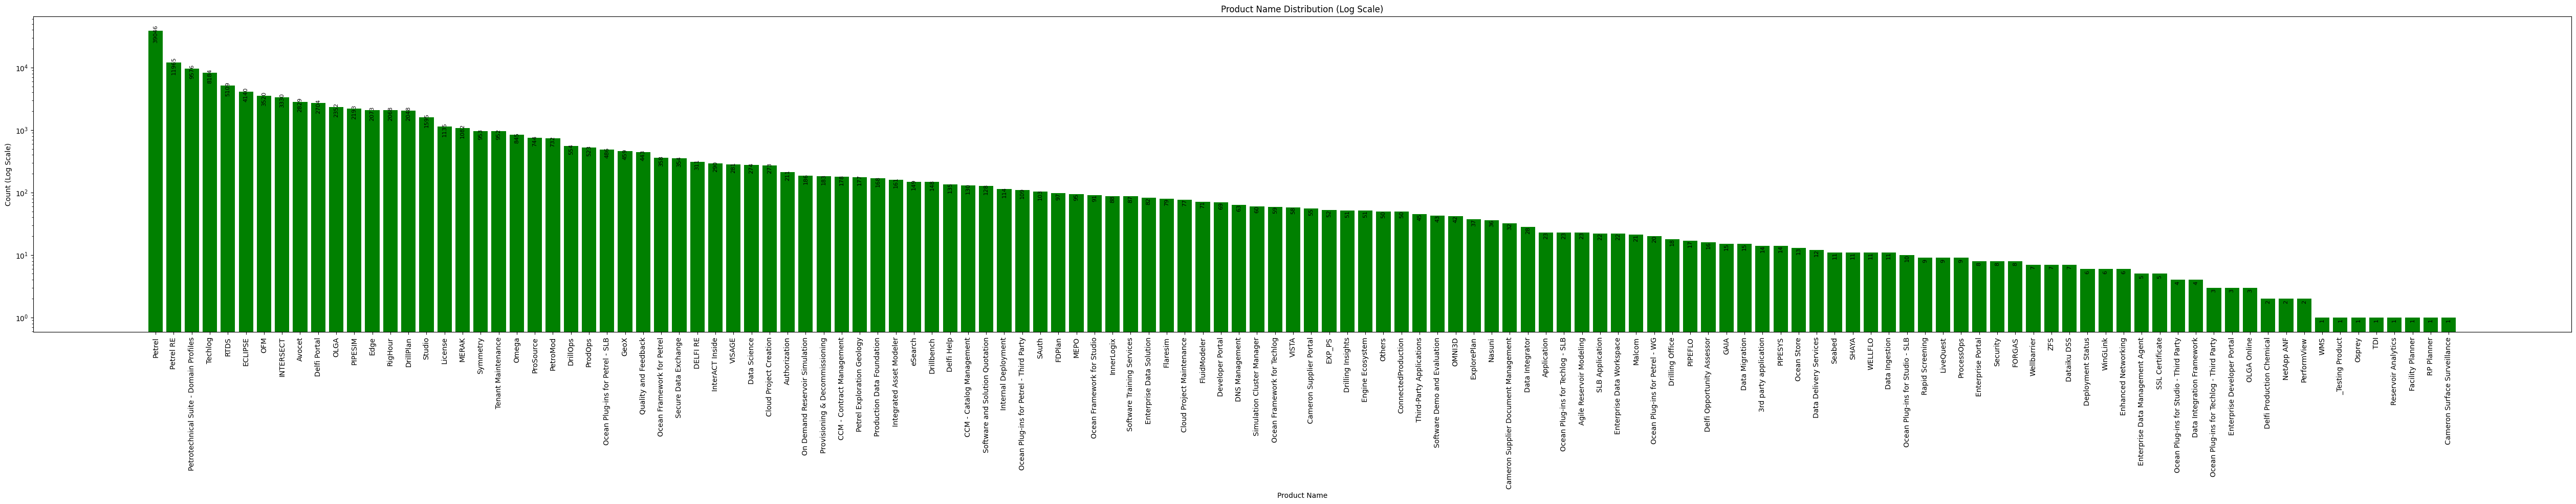

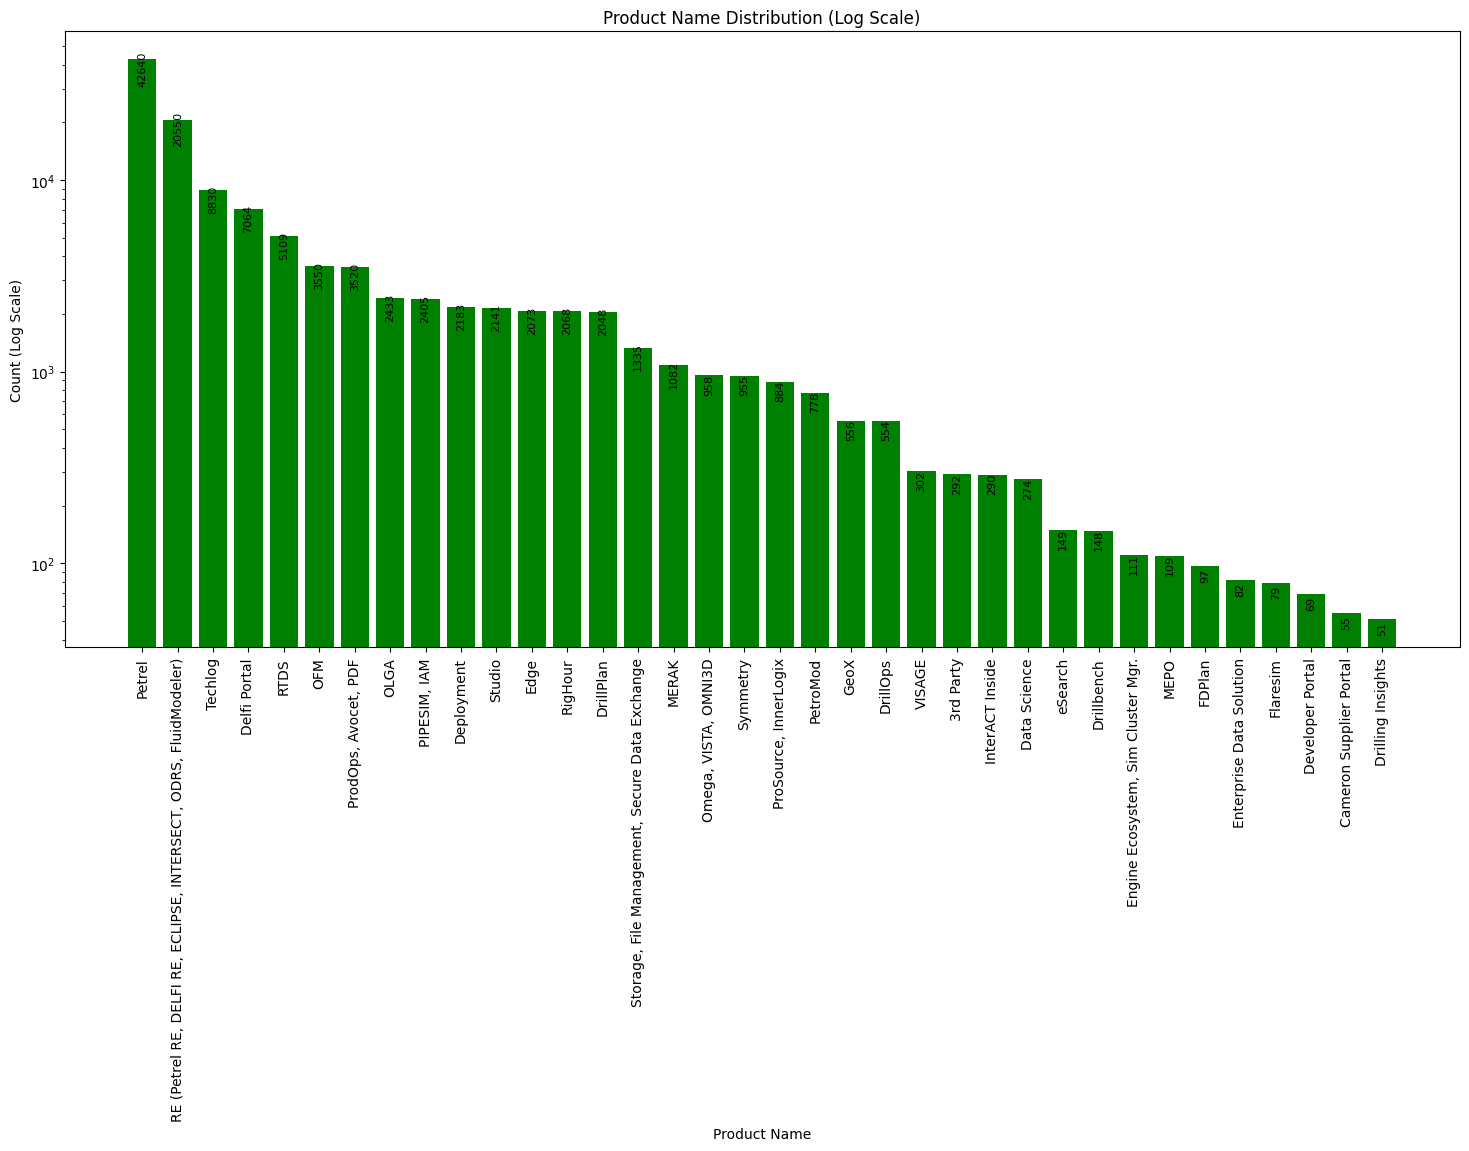

In [50]:
hist_by_labels(df_cleaned, 'Product Name', log=True, horizontal=True)
hist_by_labels(df_consolidated, 'Product Name', top=None, log=True, horizontal=True)

In [38]:
from sklearn.model_selection import train_test_split

# Specify the file name and path
excel_file_consolidated = f'{DATA_FOLDER_PATH_PROCESSED}/data_consolidated.xlsx'
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'

# split the data into train and test sets with 90% and 10% respectively of each product
df_train, df_test = train_test_split(df_consolidated, test_size=0.1, random_state=42, stratify=df_consolidated['Product Name'])

# Export the DataFrame to Excel
df_consolidated.to_excel(excel_file_consolidated, index=False)  # Set index to False if you don't want to export the DataFrame index
df_train.to_excel(excel_file_train, index=False)  # Set index to False if you don't want to export the DataFrame index
df_test.to_excel(excel_file_test, index=False)  # Set index to False if you don't want to export the DataFrame index

# Data Augmentation

In [ ]:
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'

df_train = pd.read_excel(excel_file , dtype={'Request ID': str, 'Title_Cleaned': str})
print(df_train.info())
hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:
# function to augment a dataframe with a given product name
def augment_product_data(df, target_size=500):

    result = pd.DataFrame(columns=df.columns)
    
    df_size = len(df)
    lang_agent = ['fr', 'ja', 'ru', 'es', 'ko', 'zh', 'pt', 'ar', 'de', 'it']
    
    num_iterations = min(target_size // df_size-1, len(lang_agent))
    
    for i in range(num_iterations):
        df_temp = df.copy()
        translated_titles = df_temp["Title_Translated"].tolist()
        translated_titles = translate_array(translated_titles, src_lang='en', tar_lang=lang_agent[i],length_limit=1250)
        translated_titles = translate_array(translated_titles, src_lang=lang_agent[i], tar_lang='en',length_limit=1250)

        df_temp['Title_Translated'] = translated_titles
        result = pd.concat([result, df_temp], ignore_index=True)
    return result

TARGET_SIZE = 5000
df_augmented = pd.DataFrame(columns=df_train.columns)

# filter the products which have less than 2500 records
grouped = df_train.groupby("Product Name")
# grouped = grouped.filter(lambda x : len(x)>2500)

# Initialize tqdm to display progress bar
pbar = tqdm(total=len(grouped), desc=f"Processing")

# Create an empty list to store the processed groups
processed_groups = []

# Iterate through sub DataFrames
for product, group in grouped:
    if (len(group) > TARGET_SIZE//2):
        pbar.update(1)  # Update the progress bar
        continue
    pbar.set_description(f"Processing [{product}/{len(group)}]")
    df_product = augment_product_data(group, target_size=TARGET_SIZE)

    processed_groups.append(df_product)
    pbar.update(1)  # Update the progress bar
# Close the progress bar
pbar.close()

# Concatenate the groups back into a single DataFrame
df_additional = pd.concat(processed_groups, ignore_index=True)
df_augmented = pd.concat([df_augmented, df_additional], ignore_index=True)


In [ ]:
results = df_augmented.copy()

df_augmented = pd.concat([df_train, df_augmented], ignore_index=True)

In [ ]:
print(results.info())
df_augmented.info()

In [ ]:
df_augmented['Title_Cleaned'] = df_augmented['Title_Translated'].apply(final_clean_up)
df_augmented.dropna(subset=['Title_Cleaned'], inplace=True)
df_augmented['Length'] = df_augmented['Title_Cleaned'].apply(count_words)
df_augmented.drop_duplicates(subset=['Title_Cleaned', 'Product Name'], keep='first', inplace=True)
df_augmented.drop_duplicates(subset=['Title_Cleaned'], inplace=True)

print(df_train.info())
print(df_augmented.info())

hist_by_labels(df_train, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_augmented, 'Product Name', top=None, log=True, horizontal=True)

In [ ]:

# Specify the file name and path
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_augmented.xlsx'

# Export the DataFrame to Excel
df_augmented.to_excel(excel_file, index=False)  # Set index to False if you don't want to export the DataFrame index